# 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Мы будем использовать метрику ROC_AUC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# 1. Обработка датасета

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('orange_small_churn_test_data.csv')

## Избавимся от уж совсем бесполезных данных: полностью пустых колонн

In [3]:
y_train = train['0']

nonempty_columns = train.columns[np.sum(train.isna(), axis=0) < 34000]

numeric_columns = train.columns[1:191]
numeric_columns = numeric_columns & nonempty_columns

categorical_columns = train.columns[191:-1]
categorical_columns = categorical_columns & nonempty_columns

train = train[numeric_columns.append(categorical_columns)]

## Теперь попробуем произвести отбор признаков. Основным критерием полезности признака будет - отсутствие пустот.

### Посмотрим на распределение пустот

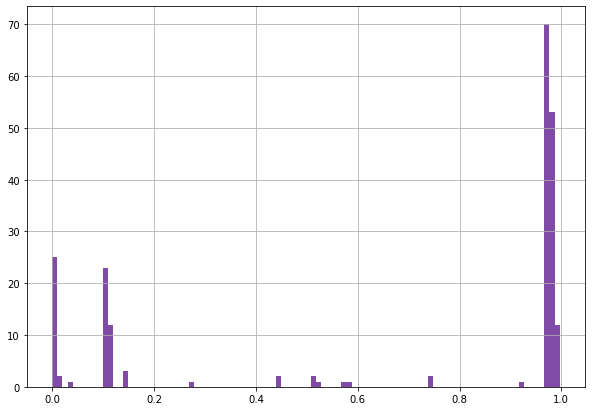

In [4]:
nan_dist = np.sum(train.isna())/34000
nan_dist.hist(figsize=(10, 7), color='indigo', bins=100, alpha=0.7);

### Мы видим, что очень много пустот сконцентрировались в последних пяти процентах

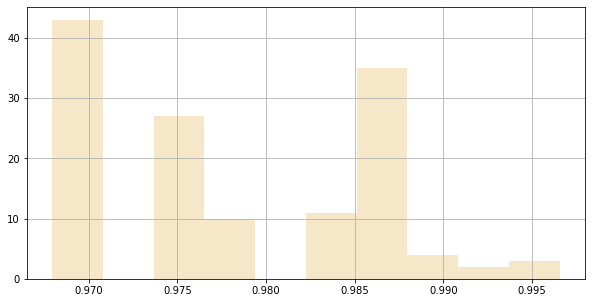

In [5]:
nan_dist[nan_dist>=0.95].hist(figsize=(10, 5), color='wheat', bins=10, alpha=0.7);

Так как catboost хорошо справяляется с заполненными признаками, нашей задачей является отбор признаков на заполнение. Гистограмма намекает на то, что можно использовать долю пустот, как параметр для отбора.

In [6]:
def emptization(data, cat_columns, num_columns, thresh=0.99):
    n = data.shape[0]
    
    cat_data = data[cat_columns]
    nan_cat_dist = np.sum(cat_data.isna()) / n
    cat_columns = nan_cat_dist[nan_cat_dist<thresh].index
    
    num_data = data[num_columns]
    nan_num_dist = np.sum(num_data.isna()) / n
    num_columns = nan_num_dist[nan_num_dist<thresh].index
    
    return cat_columns, num_columns

In [7]:
cat_cols, num_cols = emptization(train, categorical_columns, numeric_columns)

# 2. Заполнение средним

In [8]:
mean_numerical_values = train[num_cols].mean()

X_numeric = train[num_cols].fillna(mean_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_test_numeric = test[num_cols].fillna(mean_numerical_values)
X_test_categorical = test[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)

# 3. Catboost

Catboost - не очень требователен к предварительной обработки. Мало того лучше в принципе не обрабатывать данные, используя методы категоризации по типу OneHotEncoding или бинарной категоризации. По крайней мере, по моему опыту: результат получался хуже.

Мало того, нам не надо делать классический тюнинг нашей модели по типу нахождения оптимального коэффициента регуляризации. Связано это с тем, что как видно ниже, наша модель сама изучает сколько итераций (сколько деревьев) нужно сделать для идеальной модели. Фактически, метод ранней остановки уже является L2-регуляризацией. Почитать об этом подробнее можно в DeepLearningBook параграф 7.8

In [13]:
data_train = Pool(data=X_train, label=y_train, cat_features=cat_cols)

In [26]:
model = CatBoostClassifier(eval_metric='AUC')

In [27]:
model.fit(data_train)

Learning rate set to 0.046438
0:	total: 22.3ms	remaining: 22.3s
1:	total: 38ms	remaining: 18.9s
2:	total: 124ms	remaining: 41.1s
3:	total: 280ms	remaining: 1m 9s
4:	total: 413ms	remaining: 1m 22s
5:	total: 577ms	remaining: 1m 35s
6:	total: 748ms	remaining: 1m 46s
7:	total: 830ms	remaining: 1m 42s
8:	total: 918ms	remaining: 1m 41s
9:	total: 1.01s	remaining: 1m 39s
10:	total: 1.1s	remaining: 1m 39s
11:	total: 1.26s	remaining: 1m 43s
12:	total: 1.31s	remaining: 1m 39s
13:	total: 1.37s	remaining: 1m 36s
14:	total: 1.4s	remaining: 1m 31s
15:	total: 1.5s	remaining: 1m 32s
16:	total: 1.66s	remaining: 1m 36s
17:	total: 1.82s	remaining: 1m 39s
18:	total: 1.98s	remaining: 1m 42s
19:	total: 2.13s	remaining: 1m 44s
20:	total: 2.17s	remaining: 1m 41s
21:	total: 2.32s	remaining: 1m 43s
22:	total: 2.45s	remaining: 1m 44s
23:	total: 2.62s	remaining: 1m 46s
24:	total: 2.76s	remaining: 1m 47s
25:	total: 2.79s	remaining: 1m 44s
26:	total: 2.94s	remaining: 1m 45s
27:	total: 3.1s	remaining: 1m 47s
28:	tota

235:	total: 34.7s	remaining: 1m 52s
236:	total: 34.9s	remaining: 1m 52s
237:	total: 35s	remaining: 1m 52s
238:	total: 35.2s	remaining: 1m 52s
239:	total: 35.4s	remaining: 1m 52s
240:	total: 35.5s	remaining: 1m 51s
241:	total: 35.7s	remaining: 1m 51s
242:	total: 35.8s	remaining: 1m 51s
243:	total: 36s	remaining: 1m 51s
244:	total: 36s	remaining: 1m 51s
245:	total: 36.2s	remaining: 1m 50s
246:	total: 36.4s	remaining: 1m 51s
247:	total: 36.6s	remaining: 1m 51s
248:	total: 36.8s	remaining: 1m 50s
249:	total: 37s	remaining: 1m 50s
250:	total: 37.1s	remaining: 1m 50s
251:	total: 37.3s	remaining: 1m 50s
252:	total: 37.5s	remaining: 1m 50s
253:	total: 37.6s	remaining: 1m 50s
254:	total: 37.8s	remaining: 1m 50s
255:	total: 37.9s	remaining: 1m 50s
256:	total: 38.1s	remaining: 1m 50s
257:	total: 38.3s	remaining: 1m 50s
258:	total: 38.5s	remaining: 1m 50s
259:	total: 38.8s	remaining: 1m 50s
260:	total: 38.9s	remaining: 1m 50s
261:	total: 39.1s	remaining: 1m 50s
262:	total: 39.3s	remaining: 1m 50s


464:	total: 1m 15s	remaining: 1m 26s
465:	total: 1m 15s	remaining: 1m 26s
466:	total: 1m 15s	remaining: 1m 26s
467:	total: 1m 15s	remaining: 1m 26s
468:	total: 1m 16s	remaining: 1m 26s
469:	total: 1m 16s	remaining: 1m 25s
470:	total: 1m 16s	remaining: 1m 25s
471:	total: 1m 16s	remaining: 1m 25s
472:	total: 1m 16s	remaining: 1m 25s
473:	total: 1m 16s	remaining: 1m 25s
474:	total: 1m 17s	remaining: 1m 25s
475:	total: 1m 17s	remaining: 1m 25s
476:	total: 1m 17s	remaining: 1m 24s
477:	total: 1m 17s	remaining: 1m 24s
478:	total: 1m 17s	remaining: 1m 24s
479:	total: 1m 17s	remaining: 1m 24s
480:	total: 1m 18s	remaining: 1m 24s
481:	total: 1m 18s	remaining: 1m 24s
482:	total: 1m 18s	remaining: 1m 23s
483:	total: 1m 18s	remaining: 1m 23s
484:	total: 1m 18s	remaining: 1m 23s
485:	total: 1m 18s	remaining: 1m 23s
486:	total: 1m 19s	remaining: 1m 23s
487:	total: 1m 19s	remaining: 1m 23s
488:	total: 1m 19s	remaining: 1m 23s
489:	total: 1m 19s	remaining: 1m 22s
490:	total: 1m 19s	remaining: 1m 22s
4

690:	total: 1m 56s	remaining: 52.2s
691:	total: 1m 56s	remaining: 52s
692:	total: 1m 56s	remaining: 51.8s
693:	total: 1m 57s	remaining: 51.6s
694:	total: 1m 57s	remaining: 51.5s
695:	total: 1m 57s	remaining: 51.3s
696:	total: 1m 57s	remaining: 51.2s
697:	total: 1m 57s	remaining: 51s
698:	total: 1m 58s	remaining: 50.9s
699:	total: 1m 58s	remaining: 50.7s
700:	total: 1m 58s	remaining: 50.6s
701:	total: 1m 58s	remaining: 50.4s
702:	total: 1m 58s	remaining: 50.2s
703:	total: 1m 59s	remaining: 50.1s
704:	total: 1m 59s	remaining: 49.9s
705:	total: 1m 59s	remaining: 49.8s
706:	total: 1m 59s	remaining: 49.7s
707:	total: 1m 59s	remaining: 49.5s
708:	total: 2m	remaining: 49.3s
709:	total: 2m	remaining: 49.2s
710:	total: 2m	remaining: 49s
711:	total: 2m	remaining: 48.9s
712:	total: 2m 1s	remaining: 48.7s
713:	total: 2m 1s	remaining: 48.5s
714:	total: 2m 1s	remaining: 48.4s
715:	total: 2m 1s	remaining: 48.2s
716:	total: 2m 1s	remaining: 48s
717:	total: 2m 1s	remaining: 47.9s
718:	total: 2m 2s	rema

921:	total: 2m 41s	remaining: 13.6s
922:	total: 2m 41s	remaining: 13.5s
923:	total: 2m 41s	remaining: 13.3s
924:	total: 2m 41s	remaining: 13.1s
925:	total: 2m 41s	remaining: 12.9s
926:	total: 2m 42s	remaining: 12.8s
927:	total: 2m 42s	remaining: 12.6s
928:	total: 2m 42s	remaining: 12.4s
929:	total: 2m 42s	remaining: 12.2s
930:	total: 2m 42s	remaining: 12.1s
931:	total: 2m 43s	remaining: 11.9s
932:	total: 2m 43s	remaining: 11.7s
933:	total: 2m 43s	remaining: 11.6s
934:	total: 2m 43s	remaining: 11.4s
935:	total: 2m 43s	remaining: 11.2s
936:	total: 2m 44s	remaining: 11s
937:	total: 2m 44s	remaining: 10.9s
938:	total: 2m 44s	remaining: 10.7s
939:	total: 2m 44s	remaining: 10.5s
940:	total: 2m 44s	remaining: 10.3s
941:	total: 2m 45s	remaining: 10.2s
942:	total: 2m 45s	remaining: 9.99s
943:	total: 2m 45s	remaining: 9.82s
944:	total: 2m 45s	remaining: 9.64s
945:	total: 2m 45s	remaining: 9.47s
946:	total: 2m 46s	remaining: 9.29s
947:	total: 2m 46s	remaining: 9.12s
948:	total: 2m 46s	remaining: 

In [28]:
y_test = model.predict_proba(X_test)[:, 1]
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('assignment_cb_mean_99.csv', index=False)

#### Данный код позволил мне достичь результата 0.72697

Благодаря посту Артёма Глазунова на кэггле, я смог понять в каком направлении можно экспериментировать https://www.kaggle.com/c/telecom-clients-prediction2/discussion/163605 и смог довольно сильно улучшить свой результат.

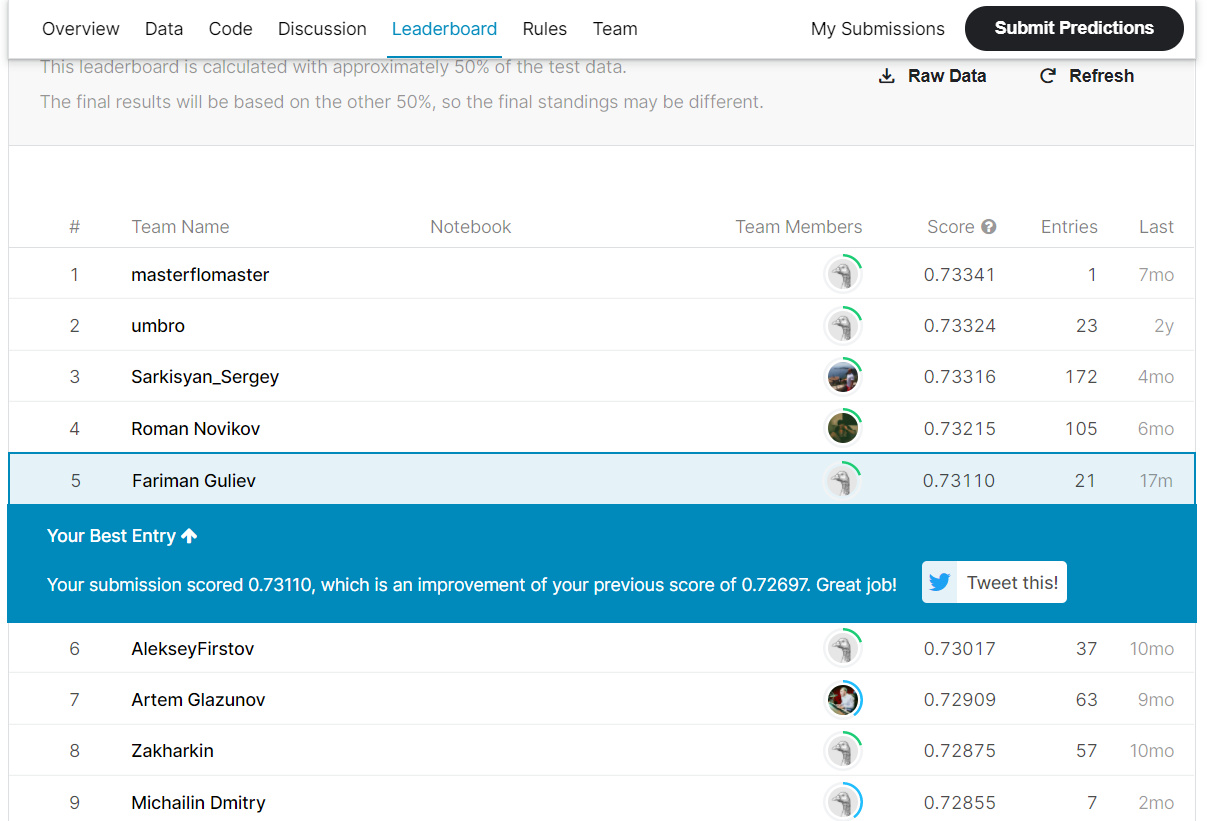

In [1]:
from IPython.display import Image
Image(filename='загрузка.png')

## Резюме:

### Что не помогло:

* Любые попытки закодить категории самостоятельно. Даже полюбившаяся мне бинарная классификация показывала более худшие результаты, чем простой CatBoost. Так как CatBoost использует решающие деревья, оно и понятно, почему так получается.
* Настройки других моделей, отличных от CatBoost
* Выбор между медианой и средним значением
* Попытка убрать имбаланс сэмплингом
* Попытка убрать имбаланс с помощью настройки весов CatBoost (было две попытки, и обе провалились, возможно, что у вас получится лучше)
* Настройка коэффициентов самого кэтбуста мне кажется не очень эффективной практикой. В конце концов эта библиотека сама умеет настраиваться.

### Что помогло:

* Использование CatBoost
* Отсеивание нановых признаков через порог
* Может как-то можно отсеять признаки по-другому? Возможно мне просто повезло, но именно рекомендации в посте Артёма Глазунова позволили мне найти хорошее поле для экспериментов. 
* CatBoost довольно высокооптимизированный и автоматический, и вряд ли его можно побить в поле алгоритмов. Однако он не очень уверенно отбирает признаки, именно поэтому мне кажется, что отбор признаков - лучшая стратегия для этого соревнования.